In [1]:
#Importing Libraries
import numpy as np
import os
import pandas as pd
from numpy import array
import keras
import seaborn as sns
import matplotlib.pyplot as plt
import re
import num2words
from tensorflow.keras import backend
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Lambda, Input, concatenate,BatchNormalization, Activation, Multiply
from keras.layers.embeddings import Embedding
from keras.layers import LSTM,Conv1D,MaxPooling1D, Bidirectional, GRU, RepeatVector, TimeDistributed, SimpleRNN
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from itertools import combinations


%matplotlib inline'

Using TensorFlow backend.


### Import Files:

In [2]:
local_path = r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/Raw/inquiry_lessons'
files_path = []
# r=root, d=directories, f = files
for r, d, f in os.walk(local_path):
    for file in f:
        if '.xlsx' in file:
            files_path.append(os.path.join(r, file))
            
n_files = len(files_path)
print('Number of Files: '+str(n_files))

Number of Files: 11


### Preprocessing Data:

In [3]:
dfs = []
for path in files_path:
    df = pd.read_excel(path)
    df = df[np.isfinite(df['Phase'])]
    df['Phase'] = df['Phase'].astype(int)-1
    df['Utterance'] = df['Utterance'].apply(lambda row: re.sub(r"(\d+)", lambda x: num2words.num2words(int(x.group(0))), row))
    df['Utterance'] = df['Utterance'].apply(lambda row: row.replace('?',' ?'))
    dfs.append(df)
docs_size = pd.Series([df.shape[0] for df in dfs])
dfs[0].head()

,StudentID,Student,time_start,time_end,Phase,Phase_start,Phase_end,Utterance
0,O2,NaN,NaN,NaN,0,1.0,NaN,Satunnaiskävely.
1,O1,NaN,NaN,NaN,0,NaN,NaN,[lukee tehtävänantoa]
2,O1,NaN,NaN,NaN,0,NaN,1.0,Voi voi. [käynnistää videon]
3,O1,NaN,NaN,NaN,0,1.0,NaN,"Missä se vaeltaa siellä ? Onks se, ei. Ei, se ..."
4,O2,NaN,NaN,NaN,0,NaN,NaN,[epäselvä]


In [4]:
#Fitting the Tokenizer on the docs:
docs = [' '.join(list(df['Utterance'].astype(str))) for df in dfs]
t = Tokenizer(filters='¡!"\'#$%&()*+,./:;<=>@[\\]^_-`{|}~\t\n',num_words=2000)
t.fit_on_texts(docs)

In [6]:
#Add Previous and Next Utterance, Number of Words and Relative Position:
i = 1
max_length = 20
for df in dfs:
    print('Processing Document '+str(i))
    i+=1
    df['Relative Position'] = df.index/len(df)
    df['Number of Words'] = df.apply(lambda row: len(row['Utterance'].split()), axis = 1)
    df['Number of Words'] = df['Number of Words']/df['Number of Words'].max()
    df['Tokenized Utterance'] = df.apply(lambda row: t.texts_to_sequences([str(row['Utterance'])])[0], axis = 1)
    df['Previous Tokenized Utterance'] = df['Tokenized Utterance'].shift(1)
    df['Next Tokenized Utterance'] = df['Tokenized Utterance'].shift(-1)
    df = df.dropna()
print('Done!')

Processing Document 1
Processing Document 2
Processing Document 3
Processing Document 4
Processing Document 5
Processing Document 6
Processing Document 7
Processing Document 8
Processing Document 9
Processing Document 10
Processing Document 11
Done!


In [7]:
def smooth_labels(labels, factor=0.1):
    # smooth the labels
    labels *= (1 - factor)
    labels += (factor / labels.shape[1])
 
    # returned the smoothed labels
    return(labels)

### Split Data:

In [8]:
#Split Training and Test Set
documents_numbers = range(11)
couple = {0,2}

#Split Training and Test Set
training_dfs = [dfs[i] for i in (set(documents_numbers)-couple)]
all_data_train = pd.concat(training_dfs).reset_index()[['Tokenized Utterance','Previous Tokenized Utterance',
                                                            'Next Tokenized Utterance' ,'Relative Position',
                                                            'Number of Words','Phase']].dropna()

X_u_train = pad_sequences(all_data_train['Tokenized Utterance'],maxlen=max_length ,padding='post')
X_pu_train = pad_sequences(all_data_train['Previous Tokenized Utterance'],maxlen=max_length ,padding='post')
X_nu_train = pad_sequences(all_data_train['Next Tokenized Utterance'],maxlen=max_length ,padding='post')

X_r_train = all_data_train['Relative Position']
X_n_train = all_data_train['Number of Words']

y_train = keras.utils.to_categorical(all_data_train['Phase'], num_classes=5, dtype='float32')
    
test_dfs = [dfs[i] for i in couple]

all_data_test = pd.concat(test_dfs).reset_index()[['Tokenized Utterance','Previous Tokenized Utterance',
                                                            'Next Tokenized Utterance' ,'Relative Position',
                                                            'Number of Words','Phase']].dropna()

X_u_test = pad_sequences(all_data_test['Tokenized Utterance'],maxlen=max_length ,padding='post')
X_pu_test = pad_sequences(all_data_test['Previous Tokenized Utterance'],maxlen=max_length ,padding='post')
X_nu_test = pad_sequences(all_data_test['Next Tokenized Utterance'],maxlen=max_length ,padding='post')

X_r_test = all_data_test['Relative Position']
X_n_test = all_data_test['Number of Words']
#y_test = keras.utils.to_categorical(all_data_test['Phase'], num_classes=5, dtype='float32')
y_test = smooth_labels(keras.utils.to_categorical(all_data_test['Phase'], num_classes=5, dtype='float32'))

/Users/pablouribepizarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [9]:
#Create Embedding Matrix:
#Load the Embeddings
from gensim.models import KeyedVectors
path = r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/finnish_4B_parsebank_skgram.bin'
wv = KeyedVectors.load_word2vec_format(path,binary=True, encoding='UTF-8',limit=500000,unicode_errors='replace') 

#Build the Embedding Matrix
max_vocab = 10000
embedding_matrix = np.zeros((max_vocab, 200))
for word, i in t.word_index.items():
    try:
        embedding_vector = wv.get_vector(word)
        embedding_matrix[i] = embedding_vector
    except:
        pass 

/Users/pablouribepizarro/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### 1. Simple Attention Model + Encoder:

In [10]:
#Shared Encoder:
vocab_size = 10000
max_length = 20

from keras.activations import softmax

def softMaxAxis1(x):
    return softmax(x,axis=1)

#Utterance inputs
utterance_input = Input(shape=(max_length,), dtype='int32', name='utterance_input')
#Previous
previous_utterance_input = Input(shape=(max_length,), dtype='int32', name='p_utterance_input')
#Next
next_utterance_input = Input(shape=(max_length,), dtype='int32', name='n_utterance_input')

#Relative Position input
rel_position_input = Input(shape=(1,), dtype='float32', name='rel_position_input')
#Number of words input
n_words_input = Input(shape=(1,), dtype='float32', name='n_words_input')

#Embedding Layer
emb = Embedding(output_dim=200, input_dim=vocab_size, input_length=max_length, weights=[embedding_matrix],trainable=False)

embedded_previous = emb(previous_utterance_input)
embedded_utterance = emb(utterance_input)
embedded_next = emb(next_utterance_input)

#Shared Encoder
encoder = Bidirectional(LSTM(5, return_sequences = True,recurrent_dropout = 0.1))

encodded_previous = encoder(embedded_previous)
encodded_utterance = encoder(embedded_utterance)
encodded_next = encoder(embedded_next)


x = concatenate([encodded_previous,encodded_utterance,encodded_next],axis = 1)

attention = TimeDistributed(Dense(1))
attention_parameters = attention(x)
attention_weigths = Activation(softMaxAxis1)(attention_parameters)

weighted_encoddings = Lambda(lambda x: x[0] * x[1])([x, attention_weigths])

#Decoder:

decoder = Lambda(lambda x: K.sum(x, axis=1))

#decoder = LSTM(10) -> Lento, malos resultados
#decoder = Flatten() -> Rápido, resultados moderados

x = decoder(weighted_encoddings)



x = concatenate([x,rel_position_input,n_words_input])

x = Dense(64, activation='relu')(x)

main_output = Dense(5, activation='softmax', name='main_output')(x)


model_5_full = Model(inputs=[previous_utterance_input,utterance_input,next_utterance_input, 
                             rel_position_input,n_words_input], outputs=[main_output])
model_5_full.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_5_full.name = 'pe_enc_simple_at'

model_5_full.save_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_5_full.name)+'.h5')

model_5_full.save(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/models/attention/'+str(model_5_full.name)+'.h5')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [11]:
model_5_full.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
p_utterance_input (InputLayer)  (None, 20)           0                                            
__________________________________________________________________________________________________
utterance_input (InputLayer)    (None, 20)           0                                            
__________________________________________________________________________________________________
n_utterance_input (InputLayer)  (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 200)      2000000     p_utterance_input[0][0]          
                                                                 utterance_input[0][0]            
          

In [12]:
#Load Initial Random Weights:
model_5_full.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_5_full.name)+'.h5')

#Checkpoint
checkpoint_5_full = ModelCheckpoint('/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_5_full.name)+'_testing.h5', 
                             verbose=1, monitor='val_acc',save_best_only=True, mode='auto')

EA = EarlyStopping(monitor='val_loss', patience=7)

#Fit Model:
history = model_5_full.fit({'p_utterance_input': X_pu_train,
                            'utterance_input': X_u_train,
                            'n_utterance_input': X_nu_train,
                            'rel_position_input': X_r_train,
                            'n_words_input': X_n_train},
                            {'main_output': y_train}, validation_data= 
                           ({'p_utterance_input': X_pu_test,
                            'utterance_input': X_u_test,
                            'n_utterance_input': X_nu_test,
                            'rel_position_input': X_r_test,
                            'n_words_input': X_n_test},
                            {'main_output': y_test}),
                           epochs=30, batch_size=64,
                            shuffle=True, callbacks = [checkpoint_5_full,EA])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1456 samples, validate on 502 samples
Epoch 1/30
1456/1456 [==============================] - 24s 17ms/step - loss: 1.6153 - acc: 0.2136 - val_loss: 1.5374 - val_acc: 0.2351

Epoch 00001: val_acc improved from -inf to 0.23506, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/pe_enc_simple_at_testing.h5
Epoch 2/30
1456/1456 [==============================] - 6s 4ms/step - loss: 1.4919 - acc: 0.3832 - val_loss: 1.4363 - val_acc: 0.3944

Epoch 00002: val_acc improved from 0.23506 to 0.39442, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/pe_enc_simple_at_testing.h5
Epoch 3/30
1456/1456 [==============================] - 6s 4ms/step - loss: 1.3871 - acc: 0.4471 - val_loss: 1.3837 - val_acc: 0.4004

Epoch 00003: val_acc improved from 0.39442 to 0.40040, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/pe_enc_simple_a

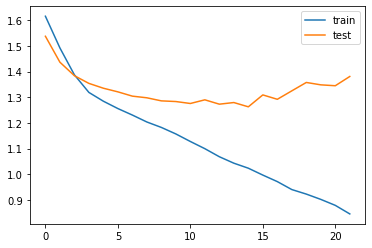

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

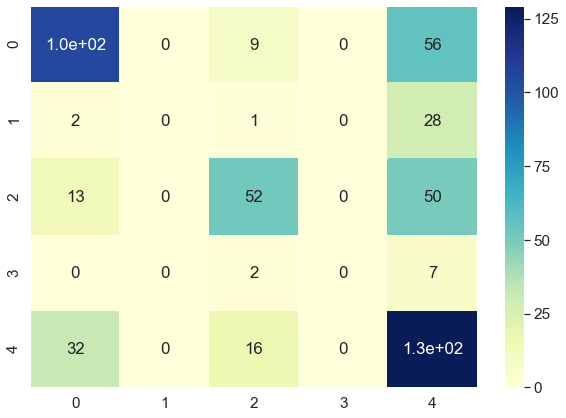

In [14]:
model_5_full.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_5_full.name)+'_testing.h5')
y_real = y_test.argmax(axis=-1)
y_pred = model_5_full.predict({'p_utterance_input': X_pu_test,
                            'utterance_input': X_u_test,
                            'n_utterance_input': X_nu_test,
                            'rel_position_input': X_r_test,
                            'n_words_input': X_n_test}).argmax(axis=-1)
results = confusion_matrix(y_real, y_pred)
df_cm = pd.DataFrame(results, index = range(5),
                  columns = range(5))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

### 3. Simple Attention, No Encoder:

In [178]:
#Shared Encoder:
vocab_size = 10000
max_length = 20

from keras.activations import softmax

def softMaxAxis1(x):
    return softmax(x,axis=1)

#Utterance inputs
utterance_input = Input(shape=(max_length,), dtype='int32', name='utterance_input')
#Previous
previous_utterance_input = Input(shape=(max_length,), dtype='int32', name='p_utterance_input')
#Next
next_utterance_input = Input(shape=(max_length,), dtype='int32', name='n_utterance_input')

#Relative Position input
rel_position_input = Input(shape=(1,), dtype='float32', name='rel_position_input')
#Number of words input
n_words_input = Input(shape=(1,), dtype='float32', name='n_words_input')

#Embedding Layer
emb = Embedding(output_dim=200, input_dim=vocab_size, input_length=max_length, weights=[embedding_matrix],trainable=False)

embedded_previous = emb(previous_utterance_input)
embedded_utterance = emb(utterance_input)
embedded_next = emb(next_utterance_input)


x = concatenate([embedded_previous,embedded_utterance,embedded_next],axis = 1)

attention = TimeDistributed(Dense(1))
attention_parameters = attention(x)
attention_weigths = Activation(softMaxAxis1)(attention_parameters)

weighted_encoddings = Lambda(lambda x: x[0] * x[1])([x, attention_weigths])

#Decoder:

decoder = Lambda(lambda x: K.sum(x, axis=1))

#decoder = LSTM(10) -> Lento, malos resultados
#decoder = Flatten() -> Rápido, resultados moderados

x = decoder(weighted_encoddings)



x = concatenate([x,rel_position_input,n_words_input])

x = Dense(64, activation='relu')(x)

main_output = Dense(5, activation='softmax', name='main_output')(x)


model_7_full = Model(inputs=[previous_utterance_input,utterance_input,next_utterance_input, 
                             rel_position_input,n_words_input], outputs=[main_output])
model_7_full.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_7_full.name = 'pe_simple_at'

model_7_full.save_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_7_full.name)+'.h5')

model_7_full.save(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/models/attention/'+str(model_7_full.name)+'.h5')

In [179]:
model_7_full.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
p_utterance_input (InputLayer)  (None, 20)           0                                            
__________________________________________________________________________________________________
utterance_input (InputLayer)    (None, 20)           0                                            
__________________________________________________________________________________________________
n_utterance_input (InputLayer)  (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 20, 200)      2000000     p_utterance_input[0][0]          
                                                                 utterance_input[0][0]            
          

In [181]:
#Load Initial Random Weights:
model_7_full.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_7_full.name)+'.h5')

#Checkpoint
checkpoint_7_full = ModelCheckpoint('/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_7_full.name)+'_testing.h5', 
                             verbose=1, monitor='val_acc',save_best_only=True, mode='auto')

EA = EarlyStopping(monitor='val_loss', patience=7)

#Fit Model:
history = model_7_full.fit({'p_utterance_input': X_pu_train,
                            'utterance_input': X_u_train,
                            'n_utterance_input': X_nu_train,
                            'rel_position_input': X_r_train,
                            'n_words_input': X_n_train},
                            {'main_output': y_train}, validation_data= 
                           ({'p_utterance_input': X_pu_test,
                            'utterance_input': X_u_test,
                            'n_utterance_input': X_nu_test,
                            'rel_position_input': X_r_test,
                            'n_words_input': X_n_test},
                            {'main_output': y_test}),
                           epochs=40, batch_size=64,
                            shuffle=True, callbacks = [checkpoint_7_full,EA])

Train on 1456 samples, validate on 502 samples
Epoch 1/40
1456/1456 [==============================] - 1s 439us/step - loss: 1.5513 - acc: 0.2795 - val_loss: 1.5173 - val_acc: 0.3247

Epoch 00001: val_acc improved from -inf to 0.32470, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/pe_simple_at_testing.h5
Epoch 2/40
1456/1456 [==============================] - 1s 420us/step - loss: 1.4499 - acc: 0.4457 - val_loss: 1.4488 - val_acc: 0.3984

Epoch 00002: val_acc improved from 0.32470 to 0.39841, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/pe_simple_at_testing.h5
Epoch 3/40
1456/1456 [==============================] - 1s 432us/step - loss: 1.3683 - acc: 0.4499 - val_loss: 1.3838 - val_acc: 0.4044

Epoch 00003: val_acc improved from 0.39841 to 0.40438, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/pe_simple_at_testing.h5
Epoch 4/40
1456/1456 [==============================] - 1s 528us/step - loss: 1.3080 - ac

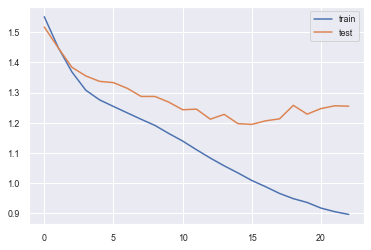

In [182]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

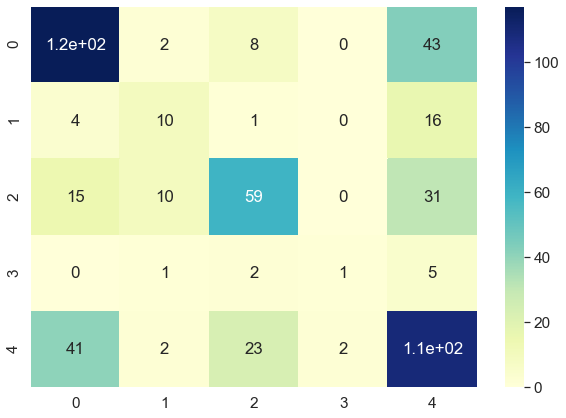

In [185]:
model_7_full.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_7_full.name)+'_testing.h5')
y_real = y_test.argmax(axis=-1)
y_pred = model_7_full.predict({'p_utterance_input': X_pu_test,
                            'utterance_input': X_u_test,
                            'n_utterance_input': X_nu_test,
                            'rel_position_input': X_r_test,
                            'n_words_input': X_n_test}).argmax(axis=-1)
results = confusion_matrix(y_real, y_pred)
df_cm = pd.DataFrame(results, index = range(5),
                  columns = range(5))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

### 4. Differentiated Attention, No Encoder

In [14]:
#Shared Encoder:
vocab_size = 10000
max_length = 20

from keras.activations import softmax

def softMaxAxis1(x):
    return softmax(x,axis=1)

#Utterance inputs
utterance_input = Input(shape=(max_length,), dtype='int32', name='utterance_input')
#Previous
previous_utterance_input = Input(shape=(max_length,), dtype='int32', name='p_utterance_input')
#Next
next_utterance_input = Input(shape=(max_length,), dtype='int32', name='n_utterance_input')

#Relative Position input
rel_position_input = Input(shape=(1,), dtype='float32', name='rel_position_input')
#Number of words input
n_words_input = Input(shape=(1,), dtype='float32', name='n_words_input')

#Embedding Layer
emb = Embedding(output_dim=200, input_dim=vocab_size, input_length=max_length, weights=[embedding_matrix],trainable=False)

embedded_previous = emb(previous_utterance_input)
embedded_utterance = emb(utterance_input)
embedded_next = emb(next_utterance_input)


utterances = concatenate([embedded_previous,embedded_utterance,embedded_next],axis = 1)

#Attention Layer

attention_1 = TimeDistributed(Dense(1))
attention_parameters_1 = attention_1(utterances)
attention_weigths_1 = Activation(softMaxAxis1, name = 'attention_1')(attention_parameters_1)

weighted_encoddings_1 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_1])

attention_2 = TimeDistributed(Dense(1))
attention_parameters_2 = attention_2(utterances)
attention_weigths_2 = Activation(softMaxAxis1, name = 'attention_2')(attention_parameters_2)

weighted_encoddings_2 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_2])

attention_3 = TimeDistributed(Dense(1))
attention_parameters_3 = attention_3(utterances)
attention_weigths_3 = Activation(softMaxAxis1, name = 'attention_3')(attention_parameters_3)

weighted_encoddings_3 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_3])

attention_4 = TimeDistributed(Dense(1))
attention_parameters_4 = attention_4(utterances)
attention_weigths_4 = Activation(softMaxAxis1, name = 'attention_4')(attention_parameters_4)

weighted_encoddings_4 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_4])

attention_5 = TimeDistributed(Dense(1))
attention_parameters_5 = attention_5(utterances)
attention_weigths_5 = Activation(softMaxAxis1, name = 'attention_5')(attention_parameters_5)

weighted_encoddings_5 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_5])

#Decoder:

decoder = Lambda(lambda x: K.sum(x, axis=1))

#Output:

x_1 = decoder(weighted_encoddings_1)
x_1 = concatenate([x_1,rel_position_input,n_words_input])
x_1 = Dense(64, activation='relu')(x_1)
output_1 = Dense(1, name='output_1')(x_1)

x_2 = decoder(weighted_encoddings_2)
x_2 = concatenate([x_2,rel_position_input,n_words_input])
x_2 = Dense(64, activation='relu')(x_2)
output_2 = Dense(1, name='output_2')(x_2)

x_3 = decoder(weighted_encoddings_3)
x_3 = concatenate([x_3,rel_position_input,n_words_input])
x_3 = Dense(64, activation='relu')(x_3)
output_3 = Dense(1, name='output_3')(x_3)

x_4 = decoder(weighted_encoddings_4)
x_4 = concatenate([x_4,rel_position_input,n_words_input])
x_4 = Dense(64, activation='relu')(x_4)
output_4 = Dense(1,name='output_4')(x_4)

x_5 = decoder(weighted_encoddings_5)
x_5 = concatenate([x_5,rel_position_input,n_words_input])
x_5 = Dense(64, activation='relu')(x_5)
output_5 = Dense(1,name='output_5')(x_5)

output = concatenate([output_1,output_2,output_3,output_4,output_5])
main_output = Activation('softmax', name= 'main_output')(output)

model_6 = Model(inputs=[previous_utterance_input,utterance_input,next_utterance_input, 
                             rel_position_input,n_words_input], outputs=[main_output])

model_6.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_6.name = 'pe_dif_at'

model_6.save_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_6.name)+'.h5')

model_6.save(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/models/attention/'+str(model_6.name)+'.h5')

In [11]:
model_6.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
p_utterance_input (InputLayer)  (None, 20)           0                                            
__________________________________________________________________________________________________
utterance_input (InputLayer)    (None, 20)           0                                            
__________________________________________________________________________________________________
n_utterance_input (InputLayer)  (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20, 200)      2000000     p_utterance_input[0][0]          
                                                                 utterance_input[0][0]            
          

In [12]:
#Load Initial Random Weights:
model_6.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_6.name)+'.h5')

#Checkpoint
checkpoint_6 = ModelCheckpoint('/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_6.name)+'_testing.h5', 
                             verbose=1, monitor='val_acc',save_best_only=True, mode='auto')

EA = EarlyStopping(monitor='val_loss', patience=7)

#Fit Model:
history = model_6.fit({'p_utterance_input': X_pu_train,
                            'utterance_input': X_u_train,
                            'n_utterance_input': X_nu_train,
                            'rel_position_input': X_r_train,
                            'n_words_input': X_n_train},
                            {'main_output': y_train}, validation_data= 
                           ({'p_utterance_input': X_pu_test,
                            'utterance_input': X_u_test,
                            'n_utterance_input': X_nu_test,
                            'rel_position_input': X_r_test,
                            'n_words_input': X_n_test},
                            {'main_output': y_test}),
                           epochs=40, batch_size=64,
                            shuffle=True, callbacks = [checkpoint_6,EA])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1456 samples, validate on 502 samples
Epoch 1/40
1456/1456 [==============================] - 7s 5ms/step - loss: 1.4523 - acc: 0.4080 - val_loss: 1.3795 - val_acc: 0.4084

Epoch 00001: val_acc improved from -inf to 0.40837, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/pe_dif_at_testing.h5
Epoch 2/40
1456/1456 [==============================] - 2s 2ms/step - loss: 1.3015 - acc: 0.4739 - val_loss: 1.3487 - val_acc: 0.4303

Epoch 00002: val_acc improved from 0.40837 to 0.43028, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/pe_dif_at_testing.h5
Epoch 3/40
1456/1456 [==============================] - 3s 2ms/step - loss: 1.2559 - acc: 0.5213 - val_loss: 1.3142 - val_acc: 0.4741

Epoch 00003: val_acc improved from 0.43028 to 0.47410, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/pe_dif_at_testing.h5
Epoch 4/40

In [106]:
#Load Best Model:

model_6.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_6.name)+'_testing.h5')

# with a Sequential model
x1 = X_pu_train
x2 = X_u_train
x3 = X_nu_train

get_attetion_layer_output_1 = K.function([model_6.layers[0].input,model_6.layers[1].input,model_6.layers[2].input],
                                  [model_6.layers[10].output])
get_attetion_layer_output_2 = K.function([model_6.layers[0].input,model_6.layers[1].input,model_6.layers[2].input],
                                  [model_6.layers[11].output])
get_attetion_layer_output_3 = K.function([model_6.layers[0].input,model_6.layers[1].input,model_6.layers[2].input],
                                  [model_6.layers[12].output])
get_attetion_layer_output_4 = K.function([model_6.layers[0].input,model_6.layers[1].input,model_6.layers[2].input],
                                  [model_6.layers[13].output])
get_attetion_layer_output_5 = K.function([model_6.layers[0].input,model_6.layers[1].input,model_6.layers[2].input],
                                  [model_6.layers[14].output])

layer_output_1 = get_attetion_layer_output_1([x1,x2,x3])[0]
layer_output_2 = get_attetion_layer_output_2([x1,x2,x3])[0]
layer_output_3 = get_attetion_layer_output_3([x1,x2,x3])[0]
layer_output_4 = get_attetion_layer_output_4([x1,x2,x3])[0]
layer_output_5 = get_attetion_layer_output_5([x1,x2,x3])[0]

y_real = y_train.argmax(axis=-1)
y_pred = model_6.predict({'p_utterance_input': X_pu_train,
                            'utterance_input': X_u_train,
                            'n_utterance_input': X_nu_train,
                            'rel_position_input': X_r_train,
                            'n_words_input': X_n_train}).argmax(axis=-1)

/Users/pablouribepizarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


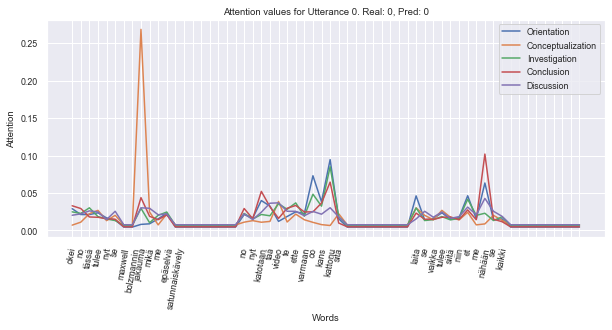

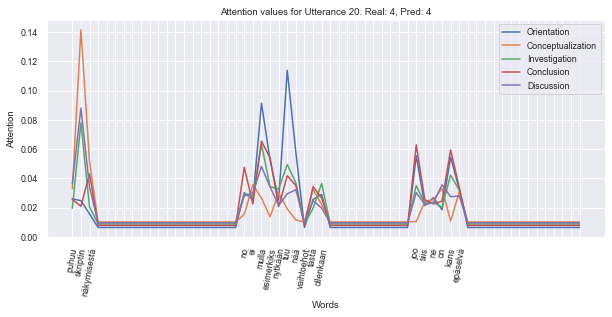

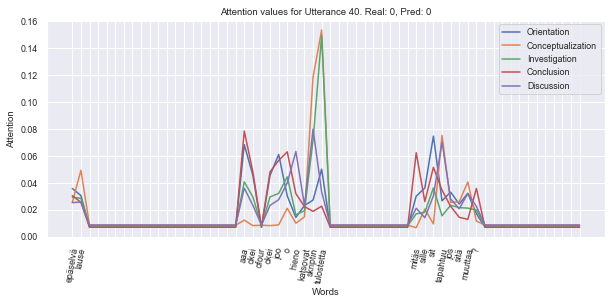

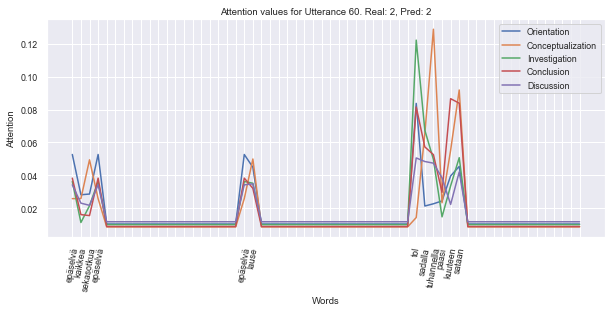

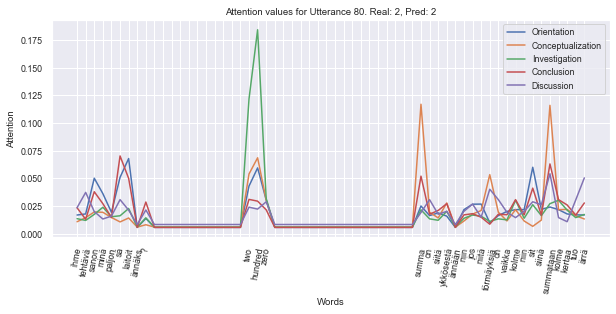

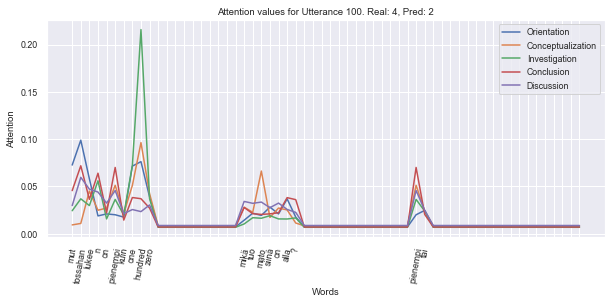

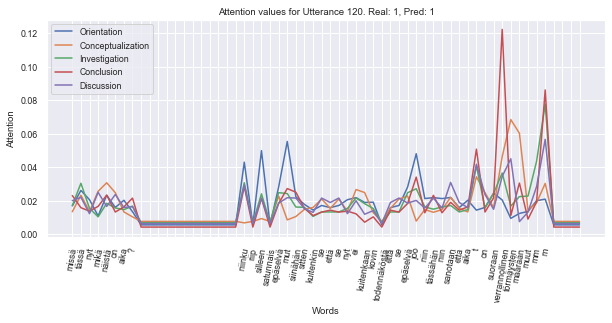

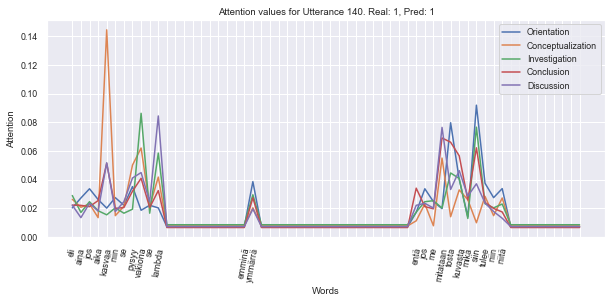

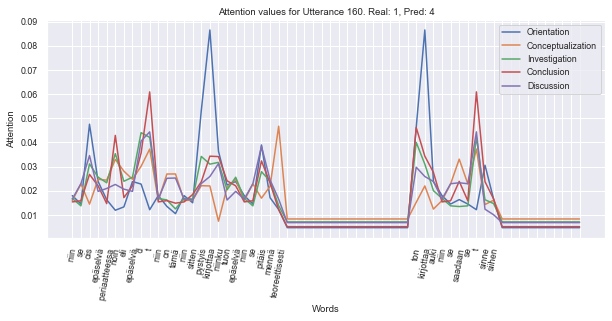

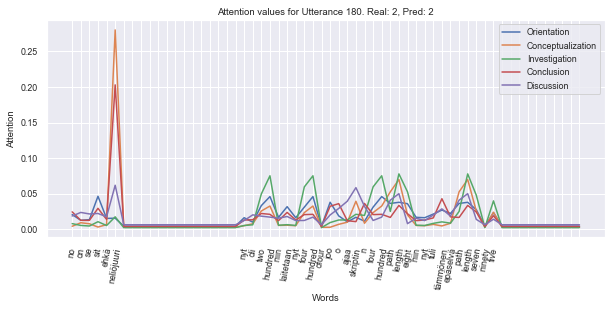

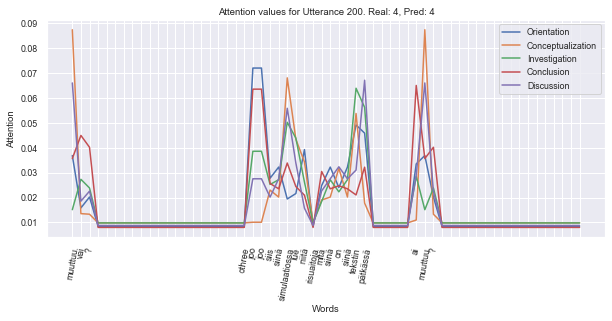

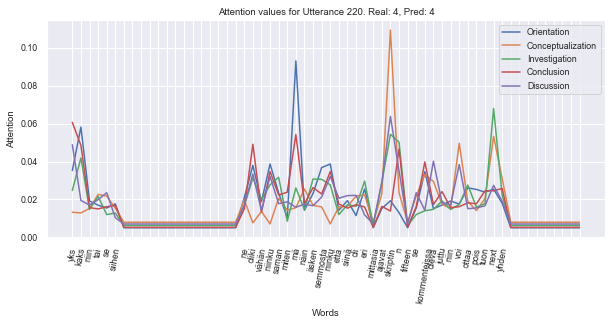

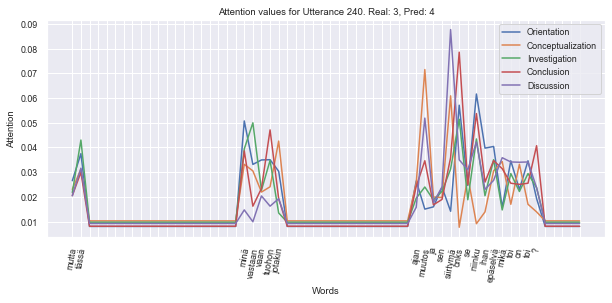

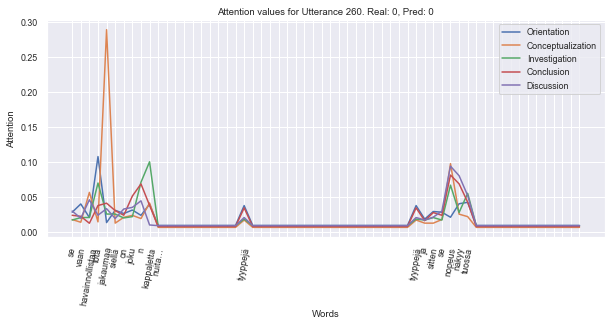

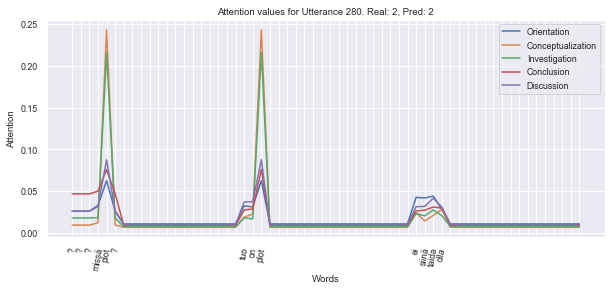

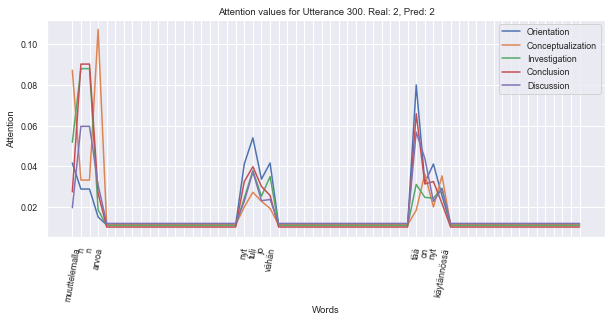

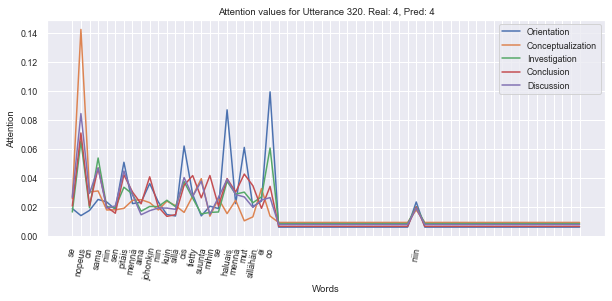

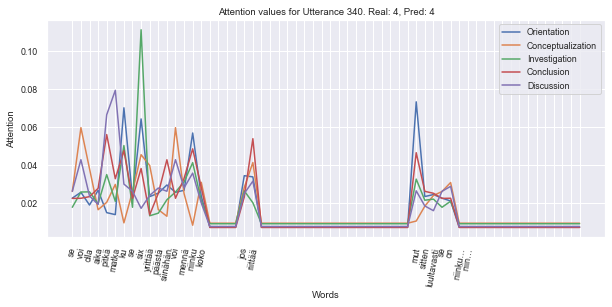

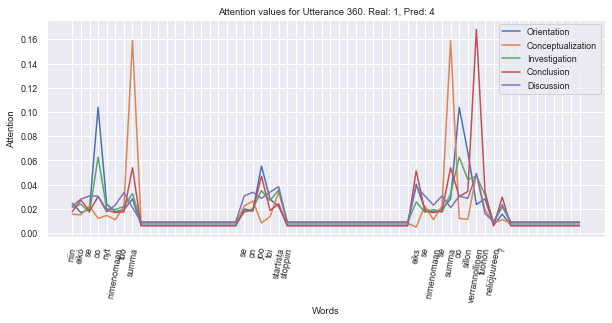

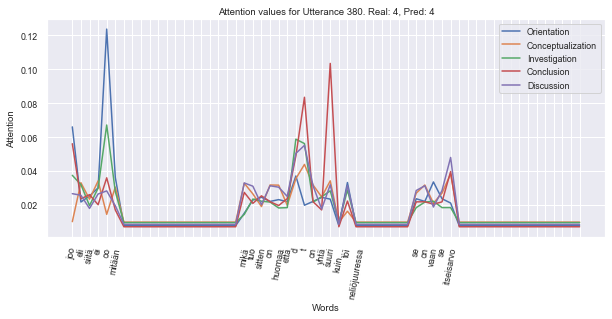

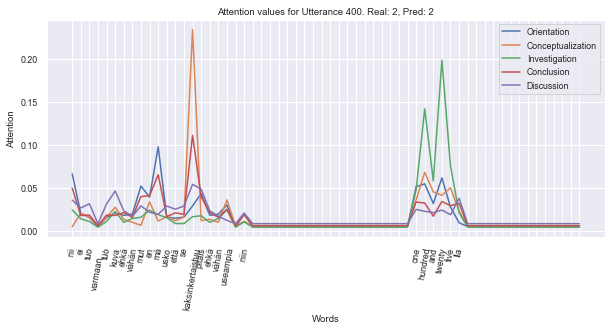

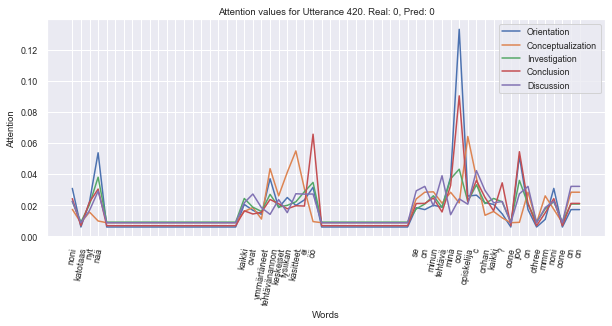

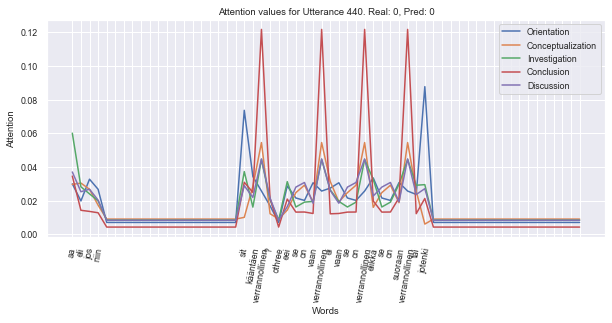

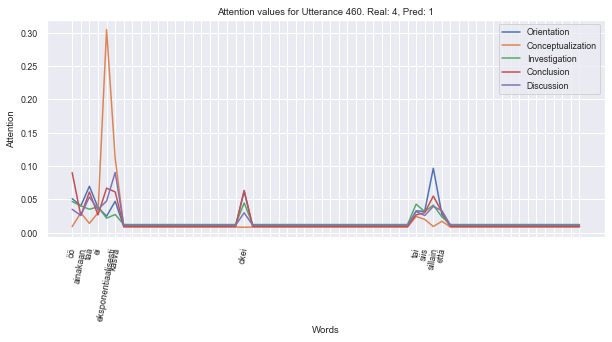

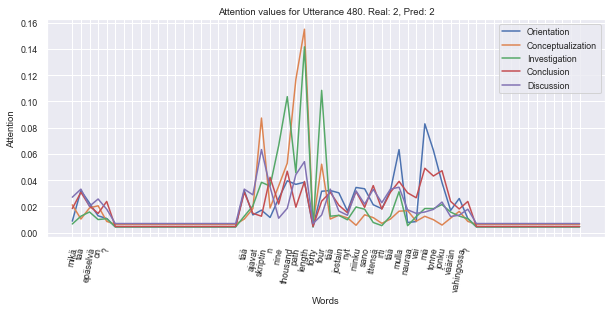

In [167]:
for i in range(0,500,20):
    tokenized = np.concatenate([x1,x2,x3],axis=1)[i]
    list_words = []

    #Tokenized Utterance -> Phrase
    for token in tokenized:
        if token == 0:
            list_words.append('')
        else:
            for name, age in t.word_index.items():
                if age == token:
                    list_words.append(name)

    plot_df_1 = pd.DataFrame(layer_output_1[i])
    plot_df_2 = pd.DataFrame(layer_output_2[i])
    plot_df_3 = pd.DataFrame(layer_output_3[i])
    plot_df_4 = pd.DataFrame(layer_output_4[i])
    plot_df_5 = pd.DataFrame(layer_output_5[i])

    plot_df = pd.concat([plot_df_1,plot_df_2,plot_df_3,plot_df_4,plot_df_5], axis = 1)
    plot_df['x'] = plot_df.index 
    plot_df.columns = ['attention_1','attention_2','attention_3','attention_4','attention_5','x'] 


    #print(list_words)
    plt.figure(figsize = (10,4))
    sns.set(font_scale=0.8)

    plt.plot(plot_df['x'],plot_df['attention_1'],label = 'Orientation')
    plt.plot(plot_df['x'],plot_df['attention_2'],label = 'Conceptualization')
    plt.plot(plot_df['x'],plot_df['attention_3'],label = 'Investigation')
    plt.plot(plot_df['x'],plot_df['attention_4'],label = 'Conclusion')
    plt.plot(plot_df['x'],plot_df['attention_5'],label = 'Discussion')
    plt.xticks(plot_df['x'], list_words, rotation=80)
    plt.title(r'Attention values for Utterance '+str(i)+'. Real: '+str(y_real[i])+', Pred: '+str(y_pred[i]))
    plt.xlabel('Words')
    plt.ylabel('Attention')
    plt.legend()
    #plt.show
    plt.savefig(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/Results/attention/dif_attention_utterance'+str(i)+'.png', bbox_inches = 'tight')


### 5. Sensitivity Analysis for Differentiated Attention

Only current utterance + number of words + relative position

In [15]:
#Shared Encoder:
vocab_size = 10000
max_length = 20

from keras.activations import softmax

def softMaxAxis1(x):
    return softmax(x,axis=1)

#Utterance inputs
utterance_input = Input(shape=(max_length,), dtype='int32', name='utterance_input')

#Relative Position input
rel_position_input = Input(shape=(1,), dtype='float32', name='rel_position_input')
#Number of words input
n_words_input = Input(shape=(1,), dtype='float32', name='n_words_input')

#Embedding Layer
emb = Embedding(output_dim=200, input_dim=vocab_size, input_length=max_length, weights=[embedding_matrix],trainable=False)

embedded_utterance = emb(utterance_input)

utterances = embedded_utterance

#Attention Layer

attention_1 = TimeDistributed(Dense(1))
attention_parameters_1 = attention_1(utterances)
attention_weigths_1 = Activation(softMaxAxis1, name = 'attention_1')(attention_parameters_1)

weighted_encoddings_1 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_1])

attention_2 = TimeDistributed(Dense(1))
attention_parameters_2 = attention_2(utterances)
attention_weigths_2 = Activation(softMaxAxis1, name = 'attention_2')(attention_parameters_2)

weighted_encoddings_2 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_2])

attention_3 = TimeDistributed(Dense(1))
attention_parameters_3 = attention_3(utterances)
attention_weigths_3 = Activation(softMaxAxis1, name = 'attention_3')(attention_parameters_3)

weighted_encoddings_3 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_3])

attention_4 = TimeDistributed(Dense(1))
attention_parameters_4 = attention_4(utterances)
attention_weigths_4 = Activation(softMaxAxis1, name = 'attention_4')(attention_parameters_4)

weighted_encoddings_4 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_4])

attention_5 = TimeDistributed(Dense(1))
attention_parameters_5 = attention_5(utterances)
attention_weigths_5 = Activation(softMaxAxis1, name = 'attention_5')(attention_parameters_5)

weighted_encoddings_5 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_5])

#Decoder:

decoder = Lambda(lambda x: K.sum(x, axis=1))

#Output:

x_1 = decoder(weighted_encoddings_1)
x_1 = concatenate([x_1,rel_position_input,n_words_input])
x_1 = Dense(64, activation='relu')(x_1)
output_1 = Dense(1, name='output_1')(x_1)

x_2 = decoder(weighted_encoddings_2)
x_2 = concatenate([x_2,rel_position_input,n_words_input])
x_2 = Dense(64, activation='relu')(x_2)
output_2 = Dense(1, name='output_2')(x_2)

x_3 = decoder(weighted_encoddings_3)
x_3 = concatenate([x_3,rel_position_input,n_words_input])
x_3 = Dense(64, activation='relu')(x_3)
output_3 = Dense(1, name='output_3')(x_3)

x_4 = decoder(weighted_encoddings_4)
x_4 = concatenate([x_4,rel_position_input,n_words_input])
x_4 = Dense(64, activation='relu')(x_4)
output_4 = Dense(1,name='output_4')(x_4)

x_5 = decoder(weighted_encoddings_5)
x_5 = concatenate([x_5,rel_position_input,n_words_input])
x_5 = Dense(64, activation='relu')(x_5)
output_5 = Dense(1,name='output_5')(x_5)

output = concatenate([output_1,output_2,output_3,output_4,output_5])
main_output = Activation('softmax', name= 'main_output')(output)

model_sa_1 = Model(inputs=[utterance_input,rel_position_input,n_words_input], outputs=[main_output])

model_sa_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_sa_1.name = 'sa_1_pe_dif_at'

model_sa_1.save_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_sa_1.name)+'.h5')

model_sa_1.save(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/models/attention/'+str(model_sa_1.name)+'.h5')

Only current utterance

In [12]:
#Shared Encoder:
vocab_size = 10000
max_length = 20

from keras.activations import softmax

def softMaxAxis1(x):
    return softmax(x,axis=1)

#Utterance inputs
utterance_input = Input(shape=(max_length,), dtype='int32', name='utterance_input')

#Relative Position input
rel_position_input = Input(shape=(1,), dtype='float32', name='rel_position_input')
#Number of words input
n_words_input = Input(shape=(1,), dtype='float32', name='n_words_input')

#Embedding Layer
emb = Embedding(output_dim=200, input_dim=vocab_size, input_length=max_length, weights=[embedding_matrix],trainable=False)

embedded_utterance = emb(utterance_input)

utterances = embedded_utterance

#Attention Layer

attention_1 = TimeDistributed(Dense(1))
attention_parameters_1 = attention_1(utterances)
attention_weigths_1 = Activation(softMaxAxis1, name = 'attention_1')(attention_parameters_1)

weighted_encoddings_1 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_1])

attention_2 = TimeDistributed(Dense(1))
attention_parameters_2 = attention_2(utterances)
attention_weigths_2 = Activation(softMaxAxis1, name = 'attention_2')(attention_parameters_2)

weighted_encoddings_2 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_2])

attention_3 = TimeDistributed(Dense(1))
attention_parameters_3 = attention_3(utterances)
attention_weigths_3 = Activation(softMaxAxis1, name = 'attention_3')(attention_parameters_3)

weighted_encoddings_3 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_3])

attention_4 = TimeDistributed(Dense(1))
attention_parameters_4 = attention_4(utterances)
attention_weigths_4 = Activation(softMaxAxis1, name = 'attention_4')(attention_parameters_4)

weighted_encoddings_4 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_4])

attention_5 = TimeDistributed(Dense(1))
attention_parameters_5 = attention_5(utterances)
attention_weigths_5 = Activation(softMaxAxis1, name = 'attention_5')(attention_parameters_5)

weighted_encoddings_5 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_5])

#Decoder:

decoder = Lambda(lambda x: K.sum(x, axis=1))

#Output:

x_1 = decoder(weighted_encoddings_1)
x_1 = Dense(64, activation='relu')(x_1)
output_1 = Dense(1, name='output_1')(x_1)

x_2 = decoder(weighted_encoddings_2)
x_2 = Dense(64, activation='relu')(x_2)
output_2 = Dense(1, name='output_2')(x_2)

x_3 = decoder(weighted_encoddings_3)
x_3 = Dense(64, activation='relu')(x_3)
output_3 = Dense(1, name='output_3')(x_3)

x_4 = decoder(weighted_encoddings_4)
x_4 = Dense(64, activation='relu')(x_4)
output_4 = Dense(1,name='output_4')(x_4)

x_5 = decoder(weighted_encoddings_5)
x_5 = Dense(64, activation='relu')(x_5)
output_5 = Dense(1,name='output_5')(x_5)

output = concatenate([output_1,output_2,output_3,output_4,output_5])
main_output = Activation('softmax', name= 'main_output')(output)

model_sa_2 = Model(inputs=[utterance_input,rel_position_input,n_words_input], outputs=[main_output])

model_sa_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_sa_2.name = 'sa_2_pe_dif_at'

model_sa_2.save_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_sa_2.name)+'.h5')

model_sa_2.save(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/models/attention/'+str(model_sa_2.name)+'.h5')

Current utterance + number of words

In [10]:
#Shared Encoder:
vocab_size = 10000
max_length = 20

from keras.activations import softmax

def softMaxAxis1(x):
    return softmax(x,axis=1)

#Utterance inputs
utterance_input = Input(shape=(max_length,), dtype='int32', name='utterance_input')
#Relative Position input
rel_position_input = Input(shape=(1,), dtype='float32', name='rel_position_input')
#Number of words input
n_words_input = Input(shape=(1,), dtype='float32', name='n_words_input')

#Embedding Layer
emb = Embedding(output_dim=200, input_dim=vocab_size, input_length=max_length, weights=[embedding_matrix],trainable=False)

embedded_utterance = emb(utterance_input)

utterances = embedded_utterance

#Attention Layer

attention_1 = TimeDistributed(Dense(1))
attention_parameters_1 = attention_1(utterances)
attention_weigths_1 = Activation(softMaxAxis1, name = 'attention_1')(attention_parameters_1)

weighted_encoddings_1 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_1])

attention_2 = TimeDistributed(Dense(1))
attention_parameters_2 = attention_2(utterances)
attention_weigths_2 = Activation(softMaxAxis1, name = 'attention_2')(attention_parameters_2)

weighted_encoddings_2 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_2])

attention_3 = TimeDistributed(Dense(1))
attention_parameters_3 = attention_3(utterances)
attention_weigths_3 = Activation(softMaxAxis1, name = 'attention_3')(attention_parameters_3)

weighted_encoddings_3 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_3])

attention_4 = TimeDistributed(Dense(1))
attention_parameters_4 = attention_4(utterances)
attention_weigths_4 = Activation(softMaxAxis1, name = 'attention_4')(attention_parameters_4)

weighted_encoddings_4 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_4])

attention_5 = TimeDistributed(Dense(1))
attention_parameters_5 = attention_5(utterances)
attention_weigths_5 = Activation(softMaxAxis1, name = 'attention_5')(attention_parameters_5)

weighted_encoddings_5 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_5])

#Decoder:

decoder = Lambda(lambda x: K.sum(x, axis=1))

#Output:

x_1 = decoder(weighted_encoddings_1)
x_1 = concatenate([x_1,n_words_input])
x_1 = Dense(64, activation='relu')(x_1)
output_1 = Dense(1, name='output_1')(x_1)

x_2 = decoder(weighted_encoddings_2)
x_2 = concatenate([x_2,n_words_input])
x_2 = Dense(64, activation='relu')(x_2)
output_2 = Dense(1, name='output_2')(x_2)

x_3 = decoder(weighted_encoddings_3)
x_3 = concatenate([x_3,n_words_input])
x_3 = Dense(64, activation='relu')(x_3)
output_3 = Dense(1, name='output_3')(x_3)

x_4 = decoder(weighted_encoddings_4)
x_4 = concatenate([x_4,n_words_input])
x_4 = Dense(64, activation='relu')(x_4)
output_4 = Dense(1,name='output_4')(x_4)

x_5 = decoder(weighted_encoddings_5)
x_5 = concatenate([x_5,n_words_input])
x_5 = Dense(64, activation='relu')(x_5)
output_5 = Dense(1,name='output_5')(x_5)

output = concatenate([output_1,output_2,output_3,output_4,output_5])
main_output = Activation('softmax', name= 'main_output')(output)

model_sa_3 = Model(inputs=[utterance_input,rel_position_input,n_words_input], outputs=[main_output])

model_sa_3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_sa_3.name = 'sa_3_pe_dif_at'

model_sa_3.save_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_sa_3.name)+'.h5')

model_sa_3.save(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/models/attention/'+str(model_sa_3.name)+'.h5')

Current utterance + relative position

In [11]:
#Shared Encoder:
vocab_size = 10000
max_length = 20

from keras.activations import softmax

def softMaxAxis1(x):
    return softmax(x,axis=1)

#Utterance inputs
utterance_input = Input(shape=(max_length,), dtype='int32', name='utterance_input')
#Relative Position input
rel_position_input = Input(shape=(1,), dtype='float32', name='rel_position_input')
#Number of words input
n_words_input = Input(shape=(1,), dtype='float32', name='n_words_input')

#Embedding Layer
emb = Embedding(output_dim=200, input_dim=vocab_size, input_length=max_length, weights=[embedding_matrix],trainable=False)

embedded_utterance = emb(utterance_input)

utterances = embedded_utterance

#Attention Layer

attention_1 = TimeDistributed(Dense(1))
attention_parameters_1 = attention_1(utterances)
attention_weigths_1 = Activation(softMaxAxis1, name = 'attention_1')(attention_parameters_1)

weighted_encoddings_1 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_1])

attention_2 = TimeDistributed(Dense(1))
attention_parameters_2 = attention_2(utterances)
attention_weigths_2 = Activation(softMaxAxis1, name = 'attention_2')(attention_parameters_2)

weighted_encoddings_2 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_2])

attention_3 = TimeDistributed(Dense(1))
attention_parameters_3 = attention_3(utterances)
attention_weigths_3 = Activation(softMaxAxis1, name = 'attention_3')(attention_parameters_3)

weighted_encoddings_3 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_3])

attention_4 = TimeDistributed(Dense(1))
attention_parameters_4 = attention_4(utterances)
attention_weigths_4 = Activation(softMaxAxis1, name = 'attention_4')(attention_parameters_4)

weighted_encoddings_4 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_4])

attention_5 = TimeDistributed(Dense(1))
attention_parameters_5 = attention_5(utterances)
attention_weigths_5 = Activation(softMaxAxis1, name = 'attention_5')(attention_parameters_5)

weighted_encoddings_5 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_5])

#Decoder:

decoder = Lambda(lambda x: K.sum(x, axis=1))

#Output:

x_1 = decoder(weighted_encoddings_1)
x_1 = concatenate([x_1,rel_position_input])
x_1 = Dense(64, activation='relu')(x_1)
output_1 = Dense(1, name='output_1')(x_1)

x_2 = decoder(weighted_encoddings_2)
x_2 = concatenate([x_2,rel_position_input])
x_2 = Dense(64, activation='relu')(x_2)
output_2 = Dense(1, name='output_2')(x_2)

x_3 = decoder(weighted_encoddings_3)
x_3 = concatenate([x_3,rel_position_input])
x_3 = Dense(64, activation='relu')(x_3)
output_3 = Dense(1, name='output_3')(x_3)

x_4 = decoder(weighted_encoddings_4)
x_4 = concatenate([x_4,rel_position_input])
x_4 = Dense(64, activation='relu')(x_4)
output_4 = Dense(1,name='output_4')(x_4)

x_5 = decoder(weighted_encoddings_5)
x_5 = concatenate([x_5,rel_position_input])
x_5 = Dense(64, activation='relu')(x_5)
output_5 = Dense(1,name='output_5')(x_5)

output = concatenate([output_1,output_2,output_3,output_4,output_5])
main_output = Activation('softmax', name= 'main_output')(output)

model_sa_4 = Model(inputs=[utterance_input,rel_position_input,n_words_input], outputs=[main_output])

model_sa_4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_sa_4.name = 'sa_4_pe_dif_at'

model_sa_4.save_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_sa_4.name)+'.h5')

model_sa_4.save(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/models/attention/'+str(model_sa_4.name)+'.h5')

In [16]:
#Shared Encoder:
vocab_size = 10000
max_length = 20

from keras.activations import softmax

def softMaxAxis1(x):
    return softmax(x,axis=1)

#Utterance inputs
utterance_input = Input(shape=(max_length,), dtype='int32', name='utterance_input')
#Previous
previous_utterance_input = Input(shape=(max_length,), dtype='int32', name='p_utterance_input')
#Next
next_utterance_input = Input(shape=(max_length,), dtype='int32', name='n_utterance_input')

#Relative Position input
rel_position_input = Input(shape=(1,), dtype='float32', name='rel_position_input')
#Number of words input
n_words_input = Input(shape=(1,), dtype='float32', name='n_words_input')

#Embedding Layer
emb = Embedding(output_dim=200, input_dim=vocab_size, input_length=max_length, weights=[embedding_matrix],trainable=False)

embedded_previous = emb(previous_utterance_input)
embedded_utterance = emb(utterance_input)
embedded_next = emb(next_utterance_input)


utterances = concatenate([embedded_previous,embedded_utterance,embedded_next],axis = 1)

#Attention Layer

attention_1 = TimeDistributed(Dense(1))
attention_parameters_1 = attention_1(utterances)
attention_weigths_1 = Activation(softMaxAxis1, name = 'attention_1')(attention_parameters_1)

weighted_encoddings_1 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_1])

attention_2 = TimeDistributed(Dense(1))
attention_parameters_2 = attention_2(utterances)
attention_weigths_2 = Activation(softMaxAxis1, name = 'attention_2')(attention_parameters_2)

weighted_encoddings_2 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_2])

attention_3 = TimeDistributed(Dense(1))
attention_parameters_3 = attention_3(utterances)
attention_weigths_3 = Activation(softMaxAxis1, name = 'attention_3')(attention_parameters_3)

weighted_encoddings_3 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_3])

attention_4 = TimeDistributed(Dense(1))
attention_parameters_4 = attention_4(utterances)
attention_weigths_4 = Activation(softMaxAxis1, name = 'attention_4')(attention_parameters_4)

weighted_encoddings_4 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_4])

attention_5 = TimeDistributed(Dense(1))
attention_parameters_5 = attention_5(utterances)
attention_weigths_5 = Activation(softMaxAxis1, name = 'attention_5')(attention_parameters_5)

weighted_encoddings_5 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_5])

#Decoder:

decoder = Lambda(lambda x: K.sum(x, axis=1))

#Output:

x_1 = decoder(weighted_encoddings_1)
x_1 = Dense(64, activation='relu')(x_1)
output_1 = Dense(1, name='output_1')(x_1)

x_2 = decoder(weighted_encoddings_2)
x_2 = Dense(64, activation='relu')(x_2)
output_2 = Dense(1, name='output_2')(x_2)

x_3 = decoder(weighted_encoddings_3)
x_3 = Dense(64, activation='relu')(x_3)
output_3 = Dense(1, name='output_3')(x_3)

x_4 = decoder(weighted_encoddings_4)
x_4 = Dense(64, activation='relu')(x_4)
output_4 = Dense(1,name='output_4')(x_4)

x_5 = decoder(weighted_encoddings_5)
x_5 = Dense(64, activation='relu')(x_5)
output_5 = Dense(1,name='output_5')(x_5)

output = concatenate([output_1,output_2,output_3,output_4,output_5])
main_output = Activation('softmax', name= 'main_output')(output)

model_sa_4 = Model(inputs=[previous_utterance_input,utterance_input,next_utterance_input, 
                             rel_position_input,n_words_input], outputs=[main_output])

model_sa_4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_sa_4.name = 'sa_5_pe_dif_at'

model_sa_4.save_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_sa_4.name)+'.h5')

model_sa_4.save(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/models/attention/'+str(model_sa_4.name)+'.h5')

### 6. Differentiated Attention, No Encoder, No number of words:

In [15]:
#Shared Encoder:
vocab_size = 10000
max_length = 20

from keras.activations import softmax

def softMaxAxis1(x):
    return softmax(x,axis=1)

#Utterance inputs
utterance_input = Input(shape=(max_length,), dtype='int32', name='utterance_input')
#Previous
previous_utterance_input = Input(shape=(max_length,), dtype='int32', name='p_utterance_input')
#Next
next_utterance_input = Input(shape=(max_length,), dtype='int32', name='n_utterance_input')

#Relative Position input
rel_position_input = Input(shape=(1,), dtype='float32', name='rel_position_input')
#Number of words input
n_words_input = Input(shape=(1,), dtype='float32', name='n_words_input')

#Embedding Layer
emb = Embedding(output_dim=200, input_dim=vocab_size, input_length=max_length, weights=[embedding_matrix],trainable=False)

embedded_previous = emb(previous_utterance_input)
embedded_utterance = emb(utterance_input)
embedded_next = emb(next_utterance_input)


utterances = concatenate([embedded_previous,embedded_utterance,embedded_next],axis = 1)

#Attention Layer

attention_1 = TimeDistributed(Dense(1))
attention_parameters_1 = attention_1(utterances)
attention_weigths_1 = Activation(softMaxAxis1, name = 'attention_1')(attention_parameters_1)

weighted_encoddings_1 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_1])

attention_2 = TimeDistributed(Dense(1))
attention_parameters_2 = attention_2(utterances)
attention_weigths_2 = Activation(softMaxAxis1, name = 'attention_2')(attention_parameters_2)

weighted_encoddings_2 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_2])

attention_3 = TimeDistributed(Dense(1))
attention_parameters_3 = attention_3(utterances)
attention_weigths_3 = Activation(softMaxAxis1, name = 'attention_3')(attention_parameters_3)

weighted_encoddings_3 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_3])

attention_4 = TimeDistributed(Dense(1))
attention_parameters_4 = attention_4(utterances)
attention_weigths_4 = Activation(softMaxAxis1, name = 'attention_4')(attention_parameters_4)

weighted_encoddings_4 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_4])

attention_5 = TimeDistributed(Dense(1))
attention_parameters_5 = attention_5(utterances)
attention_weigths_5 = Activation(softMaxAxis1, name = 'attention_5')(attention_parameters_5)

weighted_encoddings_5 = Lambda(lambda x: x[0] * x[1])([utterances, attention_weigths_5])

#Decoder:

decoder = Lambda(lambda x: K.sum(x, axis=1))

#Output:

x_1 = decoder(weighted_encoddings_1)
x_1 = concatenate([x_1,rel_position_input])
x_1 = Dense(64, activation='relu')(x_1)
output_1 = Dense(1, name='output_1')(x_1)

x_2 = decoder(weighted_encoddings_2)
x_2 = concatenate([x_2,rel_position_input])
x_2 = Dense(64, activation='relu')(x_2)
output_2 = Dense(1, name='output_2')(x_2)

x_3 = decoder(weighted_encoddings_3)
x_3 = concatenate([x_3,rel_position_input])
x_3 = Dense(64, activation='relu')(x_3)
output_3 = Dense(1, name='output_3')(x_3)

x_4 = decoder(weighted_encoddings_4)
x_4 = concatenate([x_4,rel_position_input])
x_4 = Dense(64, activation='relu')(x_4)
output_4 = Dense(1,name='output_4')(x_4)

x_5 = decoder(weighted_encoddings_5)
x_5 = concatenate([x_5,rel_position_input])
x_5 = Dense(64, activation='relu')(x_5)
output_5 = Dense(1,name='output_5')(x_5)

output = concatenate([output_1,output_2,output_3,output_4,output_5])
main_output = Activation('softmax', name= 'main_output')(output)

model_pe_dif_at_2 = Model(inputs=[previous_utterance_input,utterance_input,next_utterance_input, 
                             rel_position_input,n_words_input], outputs=[main_output])

model_pe_dif_at_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_pe_dif_at_2.name = 'pe_dif_at_2'

model_pe_dif_at_2.save_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_pe_dif_at_2.name)+'.h5')

model_pe_dif_at_2.save(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/models/attention/'+str(model_pe_dif_at_2.name)+'.h5')